# Evaluation


In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity
import glob
import re
from IPython.display import display

fp_directory = "fingerprints_chunks"
query_dir = os.path.join(fp_directory, "query")
reference_dir = os.path.join(fp_directory, "reference")

In [3]:
def load_fingerprints():
    # Load the fingerprint database
    db_path = os.path.join(fp_directory, "chunk_fingerprint_db.json")
    if os.path.exists(db_path):
        with open(db_path, 'r') as f:
            fingerprint_db = json.load(f)
        print(f"Loaded fingerprint database with {len(fingerprint_db)} entries")
    else:
        print(f"Database not found at {db_path}, scanning files directly")
        fingerprint_db = {}
    
    # Load query fingerprints
    query_files = glob.glob(os.path.join(query_dir, "*_fp.json"))
    query_fingerprints = {}
    
    print(f"Loading {len(query_files)} query fingerprints...")
    for query_file in tqdm(query_files):
        with open(query_file, 'r') as f:
            fp_data = json.load(f)
        
        # Extract video number and ID from filename
        filename = os.path.basename(query_file)
        match = re.search(r'(\d+)\[(.*?)\]_.*?_fp\.json', filename)
        if match:
            video_number = match.group(1)
            video_id = match.group(2)
            # Create a key for this fingerprint (Easier retrieval)
            key = f"{video_number}_{video_id}"
            
            query_fingerprints[key] = {
                "file": query_file,
                "data": fp_data,
                "video_id": video_id,
                "video_number": video_number
            }
    
    # Load reference fingerprints
    ref_files = glob.glob(os.path.join(reference_dir, "*_fp.json"))
    ref_fingerprints = {}
    
    print(f"Loading {len(ref_files)} reference fingerprints...")
    for ref_file in tqdm(ref_files):
        with open(ref_file, 'r') as f:
            fp_data = json.load(f)
        
        # Extract video number and reference ID from filename
        filename = os.path.basename(ref_file)
        match = re.search(r'(\d+)\[(.*?)\]_.*?reference_(.*?)_fp\.json', filename)
        if match:
            video_number = match.group(1)
            query_id = match.group(2)
            ref_id = match.group(3)
            
            # Create a key for this fingerprint (Easier retrieval)
            key = f"{video_number}_{ref_id}"
            
            ref_fingerprints[key] = {
                "file": ref_file,
                "data": fp_data,
                "video_id": ref_id,
                "query_id": query_id,
                "video_number": video_number
            }
    
    return query_fingerprints, ref_fingerprints, fingerprint_db

In [4]:
def compute_similarity(query_fp, ref_fp):
    # Get all segment fingerprints
    query_segments = query_fp["data"]["segment_fingerprints"]
    ref_segments = ref_fp["data"]["segment_fingerprints"]
    
    # Extract fingerprint vectors
    query_vectors = np.array([seg["fingerprint"] for seg in query_segments])
    ref_vectors = np.array([seg["fingerprint"] for seg in ref_segments])
    
    # Calculate pairwise cosine similarity
    similarity_matrix = sklearn_cosine_similarity(query_vectors, ref_vectors)
    
    # Get maximum similarity for each query segment
    max_similarities = np.max(similarity_matrix, axis=1)
    
    # Overall similarity is average of max similarities
    overall_similarity = np.mean(max_similarities)
    
    return {
        "overall_similarity": overall_similarity,
        "similarity_matrix": similarity_matrix,
        "max_similarities": max_similarities
    }

### Evaluate query-reference pairs similarity

In [7]:
def evaluate_query_reference():
    """
    Evaluate queries against their correct reference chunks
    """
    # Use the new loading function that handles separate query/reference directories
    query_fps, ref_fps, fp_db = load_fingerprints()
    
    print(f"Loaded {len(query_fps)} query and {len(ref_fps)} reference fingerprints")
    
    # Match queries with their corresponding references
    results = []
    
    for query_key, query_fp in tqdm(query_fps.items()):
        video_number = query_fp["video_number"]
        
        # Find matching references (with same video number)
        matching_refs = [ref for ref_key, ref in ref_fps.items() 
                         if ref["video_number"] == video_number]
        
        if not matching_refs:
            print(f"No matching reference found for query {query_key}")
            continue
            
        # We expect one reference per query
        ref_fp = matching_refs[0]
        
        # Get fingerprint segments from the data
        query_segments = query_fp["data"]["segment_fingerprints"]
        ref_segments = ref_fp["data"]["segment_fingerprints"]
        
        # Match each query segment against each reference segment
        segment_matches = []
        
        for q_idx, q_segment in enumerate(query_segments):
            q_vector = np.array(q_segment['fingerprint']).reshape(1, -1)
            
            for r_idx, r_segment in enumerate(ref_segments):
                r_vector = np.array(r_segment['fingerprint']).reshape(1, -1)
                
                # Calculate similarity
                sim = sklearn_cosine_similarity(q_vector, r_vector)[0][0]
                # Convert to percentage (0-100 scale)
                percentage = ((sim + 1) / 2) * 100
                
                segment_matches.append({
                    'q_idx': q_idx, 
                    'r_idx': r_idx,
                    'q_start': q_segment['start_time'],
                    'q_end': q_segment['end_time'],
                    'r_start': r_segment['start_time'],
                    'r_end': r_segment['end_time'],
                    'similarity': percentage
                })
        
        # Sort matches by similarity (highest first)
        segment_matches.sort(key=lambda x: x['similarity'], reverse=True)
        
        # Get best match
        best_match = segment_matches[0] if segment_matches else None
        
        # Get video information from database if available
        query_title = query_fp.get("video_title", f"Video {video_number}")
        ref_title = ref_fp.get("video_title", f"Reference for video {video_number}")
        
        # Store results for this pair
        results.append({
            'video_number': video_number,
            'query_id': query_fp["video_id"],
            'reference_id': ref_fp["video_id"],
            'query_title': query_title,
            'ref_title': ref_title,
            'best_match': best_match,
            'avg_similarity': np.mean([m['similarity'] for m in segment_matches]),
            'num_matches_above_70': sum(1 for m in segment_matches if m['similarity'] >= 70),
            'num_query_segments': len(query_segments),
            'num_ref_segments': len(ref_segments),
            'all_matches': segment_matches
        })
    
    # Calculate overall metrics
    avg_best_similarity = np.mean([r['best_match']['similarity'] for r in results if r['best_match']])
    
    print(f"Average best similarity: {avg_best_similarity:.2f}%")
    print(f"Chunks with matches above 70% similarity: {sum(1 for r in results if r['best_match'] and r['best_match']['similarity'] >= 70)}/{len(results)}")
    
    # Simple plot of best match similarities
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist([r['best_match']['similarity'] for r in results if r['best_match']], bins=20)
    plt.title('Distribution of Best Match Similarities')
    plt.xlabel('Similarity (%)')
    plt.ylabel('Count')
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist([r['avg_similarity'] for r in results], bins=20)
    plt.axvline(x=70, color='r', linestyle='--', label='70% Threshold')
    plt.title('Distribution of Average Similarities')
    plt.xlabel('Similarity (%)')
    plt.ylabel('Count')
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return a DataFrame for easier analysis
    results_df = pd.DataFrame([{
        'video_number': r['video_number'],
        'query_id': r['query_id'],
        'reference_id': r['reference_id'],
        'query_title': r['query_title'],
        'ref_title': r['ref_title'],
        'best_match_similarity': r['best_match']['similarity'] if r['best_match'] else None,
        'avg_similarity': r['avg_similarity'],
        'num_matches_above_70': r['num_matches_above_70'],
        'num_query_segments': r['num_query_segments'],
        'num_ref_segments': r['num_ref_segments'],
    } for r in results])
    
    display(results_df.sort_values('best_match_similarity', ascending=False))
    
    return results, results_df

Database not found at fingerprints_chunks/chunk_fingerprint_db.json, scanning files directly
Loading 74 query fingerprints...


  0%|          | 0/74 [00:00<?, ?it/s]

Loading 74 reference fingerprints...


  0%|          | 0/74 [00:00<?, ?it/s]

Loaded 15 query and 35 reference fingerprints


  0%|          | 0/15 [00:00<?, ?it/s]

Average best similarity: 99.17%
Chunks with matches above 70% similarity: 15/15


/tmp/ipykernel_31455/3706560789.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


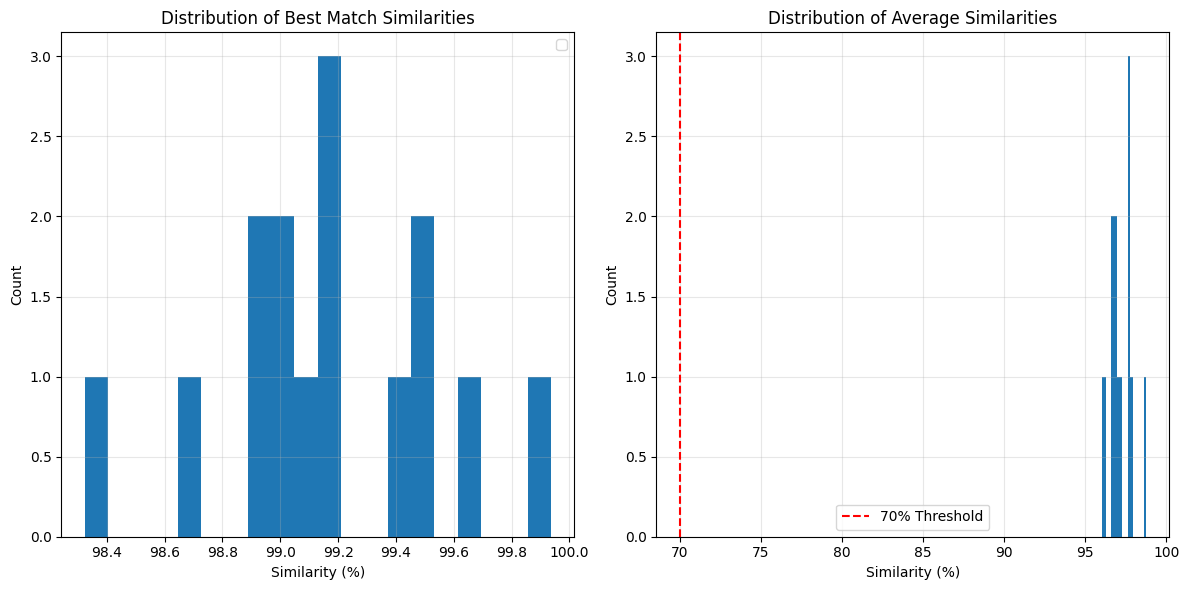

,video_number,query_id,reference_id,query_title,ref_title,best_match_similarity,avg_similarity,num_matches_above_70,num_query_segments,num_ref_segments
4,004,MnfnAptvNQ,k1QpRMBKCWQ,Video 004,Reference for video 004,99.935835,96.616797,84681,291,291
10,010,vs49hrI1bis,Tu8SH6FbN0Q,Video 010,Reference for video 010,99.635815,98.732902,1179,131,9
12,012,abAPtv7HISA,aZ31hfOBqMo,Video 012,Reference for video 012,99.527038,97.717917,16637,131,127
6,006,e5LH6WIIlSs,Ik21AAjmHVY,Video 006,Reference for video 006,99.460102,97.685782,17195,95,181
14,014,eWh9NgFyaz0,6O8ij0TELJk,Video 014,Reference for video 014,99.430437,96.637990,87567,289,303
3,003,ZupxakzVLEk,lkprxUbLPnM,Video 003,Reference for video 003,99.201523,96.292596,75625,275,275
0,000,YzHOD9t1fKM,hTDb0ebFh8E,Video 000,Reference for video 000,99.179996,96.862077,43225,247,175
11,011,RQurJCHgD1w,53uqUok1FF4,Video 011,Reference for video 011,99.142876,97.674095,11211,101,111
7,007,eQ7YB3rgAmA,H58vbez_m4E,Video 007,Reference for video 007,99.109736,96.854308,20449,143,143
9,009,lAwqPWYN2UU,tvTRZJ-4EyI,Video 009,Reference for video 009,99.048793,97.236119,851,37,23


In [8]:
results, results_df = evaluate_query_reference()

In [ ]:
def evaluate_specific_pair(fp_directory, query_chunk_idx, reference_chunk_idx=None):
    """
    Evaluate a specific query chunk against a specific reference chunk
    Includes a time-aligned visualization to compare segments
    """
    fingerprints = load_fingerprints(fp_directory)
    print(f"Loaded {len(fingerprints)} fingerprint files")
    
    # Find the query fingerprint
    query_fp = None
    query_filename = None
    
    for filename, fp_data in fingerprints.items():
        if f"chunk{query_chunk_idx}_query" in filename:
            query_fp = fp_data
            query_filename = filename
            break
    
    if not query_fp:
        print(f"Error: No query fingerprint found for chunk {query_chunk_idx}")
        return None
    
    # If reference chunk not specified, use the same index as the query
    if reference_chunk_idx is None:
        reference_chunk_idx = query_chunk_idx
    
    # Find the reference fingerprint
    ref_fp = None
    ref_filename = None
    
    for filename, fp_data in fingerprints.items():
        if f"chunk{reference_chunk_idx}_reference" in filename:
            ref_fp = fp_data
            ref_filename = filename
            break
    
    if not ref_fp:
        print(f"Error: No reference fingerprint found for chunk {reference_chunk_idx}")
        return None
    
    print(f"Comparing query {query_filename} to reference {ref_filename}")
    
    # Extract segments
    query_segments = query_fp['segment_fingerprints']
    ref_segments = ref_fp['segment_fingerprints']
    
    print(f"Query has {len(query_segments)} segments")
    print(f"Reference has {len(ref_segments)} segments")
    
    # Get chunk timing information
    query_start_time = query_fp['chunk_start_time']
    query_end_time = query_fp['chunk_end_time'] 
    query_duration = query_end_time - query_start_time
    
    ref_start_time = ref_fp['chunk_start_time']
    ref_end_time = ref_fp['chunk_end_time']
    ref_duration = ref_end_time - ref_start_time
    
    print(f"Query chunk time: {query_start_time:.2f}s - {query_end_time:.2f}s (duration: {query_duration:.2f}s)")
    print(f"Reference chunk time: {ref_start_time:.2f}s - {ref_end_time:.2f}s (duration: {ref_duration:.2f}s)")
    
    # Compare each query segment to each reference segment
    segment_matches = []
    
    for q_idx, q_segment in enumerate(query_segments):
        q_vector = np.array(q_segment['fingerprint']).reshape(1, -1)
        
        for r_idx, r_segment in enumerate(ref_segments):
            r_vector = np.array(r_segment['fingerprint']).reshape(1, -1)
            
            # Calculate similarity
            sim = sklearn_cosine_similarity(q_vector, r_vector)[0][0]
            percentage = ((sim + 1) / 2) * 100
            
            segment_matches.append({
                'q_idx': q_idx, 
                'r_idx': r_idx,
                'q_start': q_segment['start_time'],
                'q_end': q_segment['end_time'],
                'r_start': r_segment['start_time'],
                'r_end': r_segment['end_time'],
                'similarity': percentage
            })
    
    # Sort matches by similarity
    segment_matches.sort(key=lambda x: x['similarity'], reverse=True)
    
    # Print top 5 segment matches
    print("\nTop 5 segment matches:")
    for i, match in enumerate(segment_matches[:5]):
        print(f"{i+1}. Query segment {match['q_idx']} ({match['q_start']:.2f}s-{match['q_end']:.2f}s) ↔ "
              f"Ref segment {match['r_idx']} ({match['r_start']:.2f}s-{match['r_end']:.2f}s): "
              f"{match['similarity']:.2f}%")
    
    # Calculate overall statistics
    avg_similarity = np.mean([m['similarity'] for m in segment_matches])
    best_similarity = segment_matches[0]['similarity'] if segment_matches else 0
    
    print(f"Average similarity: {avg_similarity:.2f}%")
    print(f"Best similarity: {best_similarity:.2f}%")
    
    # Visualize segment match matrix
    plt.figure(figsize=(8, 4))
    
    # Create similarity matrix for visualization
    max_q_idx = max(m['q_idx'] for m in segment_matches) + 1
    max_r_idx = max(m['r_idx'] for m in segment_matches) + 1
    
    sim_matrix = np.zeros((max_q_idx, max_r_idx))
    for match in segment_matches:
        sim_matrix[match['q_idx'], match['r_idx']] = match['similarity']
    
    plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Similarity (%)')
    plt.xlabel('Reference Segment Index')
    plt.ylabel('Query Segment Index')
    plt.title(f'Segment Similarity Matrix: Query {query_chunk_idx} vs Reference {reference_chunk_idx}')
    plt.tight_layout()
    plt.show()
    
    
    # Return the complete results
    return {
        'query_chunk': query_chunk_idx,
        'reference_chunk': reference_chunk_idx,
        'segment_matches': segment_matches,
        'best_match': segment_matches[0] if segment_matches else None,
        'avg_similarity': avg_similarity,
        'best_similarity': best_similarity,
        'total_comparisons': len(segment_matches)
    }

Loaded 144 fingerprint files
Comparing query 000[YzHOD9t1fKM]_chunk1_query_fp.json to reference 000[YzHOD9t1fKM]_chunk1_reference_hTDb0ebFh8E_fp.json
Query has 169 segments
Reference has 175 segments
Query chunk time: 19.00s - 104.00s (duration: 85.00s)
Reference chunk time: 0.00s - 88.00s (duration: 88.00s)

Top 5 segment matches:
1. Query segment 163 (100.50s-101.50s) ↔ Ref segment 27 (13.50s-14.50s): 99.24%
2. Query segment 26 (32.00s-33.00s) ↔ Ref segment 12 (6.00s-7.00s): 99.11%
3. Query segment 106 (72.00s-73.00s) ↔ Ref segment 27 (13.50s-14.50s): 99.07%
4. Query segment 106 (72.00s-73.00s) ↔ Ref segment 17 (8.50s-9.50s): 99.07%
5. Query segment 14 (26.00s-27.00s) ↔ Ref segment 12 (6.00s-7.00s): 99.03%
Average similarity: 96.33%
Best similarity: 99.24%


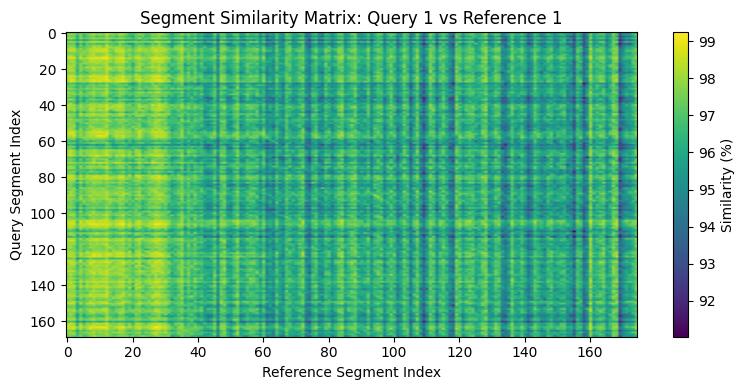

In [80]:
# Compare query chunk 1 with reference chunk 1 (its correct reference)
pair_results = evaluate_specific_pair(fp_directory, query_chunk_idx=1)

# Compare query chunk 1 with reference chunk 2 (a different reference)
# different_pair = evaluate_specific_pair(fp_directory, query_chunk_idx=1, reference_chunk_idx=)

In [81]:
def evaluate_against_all_references(fp_directory, query_indices=None, top_n=3):
    """
    Evaluate specific queries against all reference chunks
    """
    fingerprints = load_fingerprints_from_directory(fp_directory)
    print(f"Loaded {len(fingerprints)} fingerprint files")
    
    # Extract all queries and references
    queries = {}
    references = {}
    
    for filename, fp_data in fingerprints.items():
        match = re.search(r'chunk(\d+)', filename)
        if not match:
            continue
            
        chunk_idx = int(match.group(1))
        
        if 'query' in filename:
            queries[chunk_idx] = fp_data
        elif 'reference' in filename:
            references[chunk_idx] = fp_data
    
    print(f"Found {len(queries)} queries and {len(references)} references")
    
    # Select queries to evaluate
    if query_indices is None:
        # Use first 5 queries by default
        query_indices = sorted(list(queries.keys()))[:5]
    
    results = {}
    
    for query_idx in query_indices:
        if query_idx not in queries:
            print(f"Query {query_idx} not found, skipping")
            continue
            
        print(f"\nEvaluating query {query_idx}...")
        query_data = queries[query_idx]
        query_segments = query_data['segment_fingerprints']
        
        # Match against all references
        ref_matches = {}
        
        for ref_idx, ref_data in references.items():
            ref_segments = ref_data['segment_fingerprints']
            segment_matches = []
            
            for q_idx, q_segment in enumerate(query_segments):
                q_vector = np.array(q_segment['fingerprint']).reshape(1, -1)
                
                for r_idx, r_segment in enumerate(ref_segments):
                    r_vector = np.array(r_segment['fingerprint']).reshape(1, -1)
                    
                    # Calculate similarity
                    sim = sklearn_cosine_similarity(q_vector, r_vector)[0][0]
                    percentage = ((sim + 1) / 2) * 100
                    
                    if percentage >= 70:  # Only consider good matches
                        segment_matches.append({
                            'q_idx': q_idx, 
                            'r_idx': r_idx,
                            'q_start': q_segment['start_time'],
                            'q_end': q_segment['end_time'],
                            'r_start': r_segment['start_time'],
                            'r_end': r_segment['end_time'],
                            'similarity': percentage
                        })
            
            # Get best match for this reference
            if segment_matches:
                segment_matches.sort(key=lambda x: x['similarity'], reverse=True)
                best_match = segment_matches[0]
                
                ref_matches[ref_idx] = {
                    'best_match': best_match,
                    'similarity': best_match['similarity'],
                    'num_matches': len(segment_matches),
                    'is_correct': (ref_idx == query_idx)
                }
        
        # Sort references by similarity
        sorted_matches = sorted(ref_matches.items(), key=lambda x: x[1]['similarity'], reverse=True)
        top_matches = sorted_matches[:top_n]
        
        # Print top matches
        print(f"Top {top_n} matches for query {query_idx}:")
        for i, (ref_idx, match_data) in enumerate(top_matches):
            marker = "✓" if match_data['is_correct'] else "✗"
            print(f"{i+1}. Reference {ref_idx}: {match_data['similarity']:.2f}% {marker}")
            best = match_data['best_match']
            print(f"   Query segment {best['q_idx']} ({best['q_start']:.2f}s-{best['q_end']:.2f}s) → " 
                  f"Ref segment {best['r_idx']} ({best['r_start']:.2f}s-{best['r_end']:.2f}s)")
        
        # Plot top matches
        plt.figure(figsize=(12, 5))
        plot_refs = [ref_idx for ref_idx, _ in sorted_matches[:10]]  # Show top 10
        plot_sims = [match_data['similarity'] for _, match_data in sorted_matches[:10]]
        colors = ['green' if ref_idx == query_idx else 'gray' for ref_idx, _ in sorted_matches[:10]]
        
        plt.bar(range(len(plot_refs)), plot_sims, color=colors)
        plt.xticks(range(len(plot_refs)), plot_refs)
        plt.axhline(y=70, color='r', linestyle='--')
        plt.title(f'Top matches for Query {query_idx}')
        plt.xlabel('Reference Chunk Index')
        plt.ylabel('Similarity (%)')
        plt.grid(alpha=0.3)
        plt.show()
        
        # Check if correct match is in top N
        correct_position = next((i+1 for i, (ref_idx, _) in enumerate(sorted_matches) 
                                if ref_idx == query_idx), None)
        
        results[query_idx] = {
            'top_matches': top_matches,
            'correct_position': correct_position,
            'correct_in_top_n': correct_position is not None and correct_position <= top_n,
            'all_matches': sorted_matches
        }
    
    # Summarize results
    correct_count = sum(1 for r in results.values() if r['correct_in_top_n'])
    print(f"\nSummary: {correct_count}/{len(results)} queries have correct match in top {top_n}")
    
    return results

Loaded 144 fingerprint files
Found 72 queries and 72 references

Evaluating query 1...
Top 3 matches for query 1:
1. Reference 31: 99.31% ✗
   Query segment 163 (100.50s-101.50s) → Ref segment 8 (4.00s-5.00s)
2. Reference 48: 99.26% ✗
   Query segment 14 (26.00s-27.00s) → Ref segment 2 (1.00s-2.00s)
3. Reference 49: 99.26% ✗
   Query segment 14 (26.00s-27.00s) → Ref segment 2 (1.00s-2.00s)


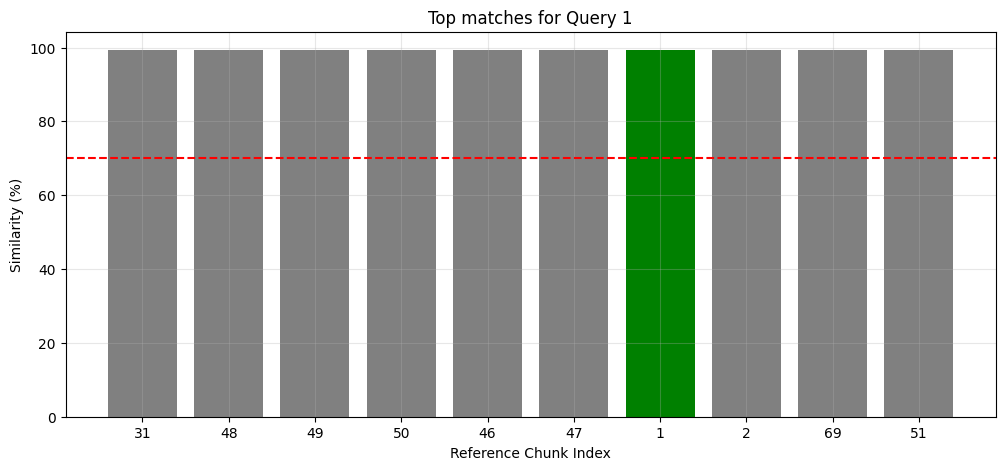


Summary: 0/1 queries have correct match in top 3


In [82]:
all_ref_results = evaluate_against_all_references(fp_directory, [1], top_n=3)

In [ ]:
all_ref_results = evaluate_against_all_references(fp_directory, top_n=3)